# Hawkes process

## MACS 207B Poisson Process

### Arnaud Capitan

___

Librairies I will be using for this project :

In [ ]:
import scipy
import pandas as pd
from datetime import datetime
from collections import Counter
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm #Progress bar for loops

___

### Context :

In Cyber security, attacks often occur by bursts. The following file contains the dates of plenty of attacks, sorted by category and date of appearance.

https://nextcloud.r2.enst.fr/nextcloud/index.php/s/DzfPE8Axx2H2afM

For a complete description of its content and the motivations behind this analysis, see the following link :

https://nextcloud.r2.enst.fr/nextcloud/index.php/s/xW2b6FF9ikPR8Gs

___

We first extract from the file mentioned above the attacks of type “HACK”.

The dates are expressed in days starting from the first event :

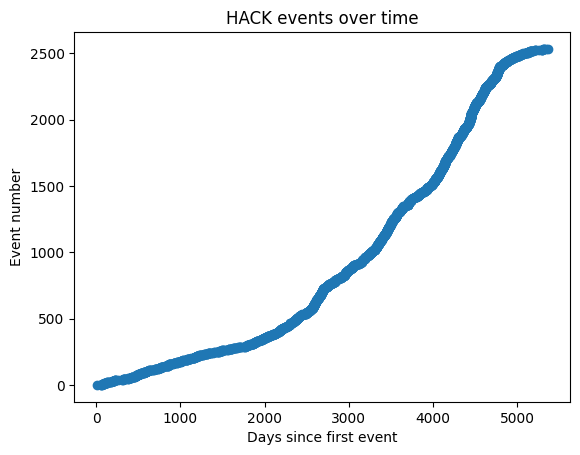

In [233]:
df=pd.read_csv("PRC.csv",sep=';')
dff=df.loc[df['Type of breach']=="HACK",'Date Made Public']
dff=dff.apply(lambda x:datetime.strptime(x,'%m/%d/%Y'))
debut=min(dff)
dff=dff-debut
dff=dff.apply(lambda x:x.days).sort_values()
l=np.asarray(dff)[1:]
plt.scatter(l,1+np.arange(len(l)))
plt.title("HACK events over time")
plt.xlabel("Days since first event")
plt.ylabel("Event number")
plt.show()

The array $l$ contains the dates in days of the different events since the first attack.

We can plot the attacks intensity over time :

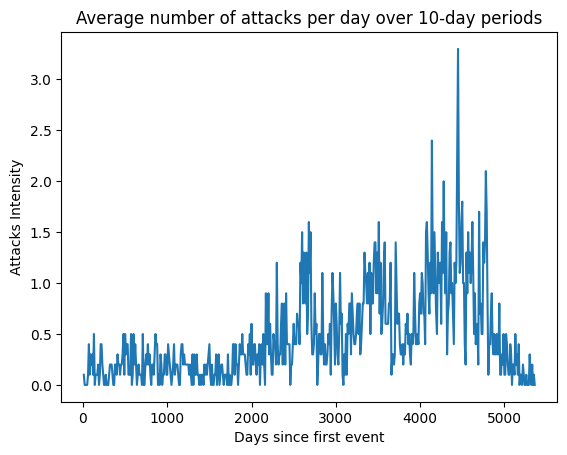

Period of study : 5364 days
Total number of attacks over this time : 2532
Average number of attacks per day : 0.47


In [234]:
n_days = 10
points = np.arange(n_days, l[-1], n_days)
intensities = []

for t in points:
    count = np.sum((t-n_days <= l) & (l < t))
    intensities.append(count/n_days)

plt.plot(points, intensities)
plt.xlabel('Days since first event')
plt.ylabel(f'Attacks Intensity')
plt.title(f'Average number of attacks per day over {n_days}-day periods')
plt.show()

print(f"Period of study : {l[-1]} days")
print(f"Total number of attacks over this time : {len(l)}")
print(f"Average number of attacks per day : {len(l)/l[-1]:.2f}")

___

We are going to make a simplified analysis by modeling time of attacks by a Hawkes process with intensity :

$$\hat{y}(N,t) = \alpha + \beta \int _0 ^{t^{-}} e^{-\gamma (t-s)} dN(s)$$

We know that log-likelihood is given by :

$$ \ln L(N,t) = \sum _{T_n \leq t} \ln (\alpha + \beta \sum _{j=1} ^{n-1} e^{- \gamma (T_n - T_j)}) + (1 - \alpha)t -\dfrac{\beta}{\gamma} \sum _{T_n \leq t} (1-e^{-\gamma(t-T_n)}) $$

___


We want to estimate the parameters $\alpha$, $\beta$ and $\gamma$ to minimize the negative log-likelihood, which is equivalent to maximizing the log-likelihood.

We define the following function to minimize the negative log-likelihood with respect to parameters $\alpha$, $\beta$ and $\gamma$.

In [235]:
def neg_log_likelihood(params, l, t):
    alpha, beta, gamma = params
    if alpha <= 0 or beta <= 0 or gamma <= 0: #Constraints on parameters
        return np.inf
    n = len(l)
    log_likelihood_result = 0
    for i in range(n): #For all events
        Tn = l[i] # Time of the current event
        if i == 0: #If it's the first event, we return 0 as there are no prior events
            sum_exp = 0
        else:
            sum_exp = np.sum(np.exp(-gamma*(Tn-l[:i])))
        intensity = alpha + beta*sum_exp
        log_likelihood_result += np.log(max(intensity, 1e-9))
    log_likelihood_result += (1-alpha)*t
    log_likelihood_result -= (beta/gamma)*np.sum(1 - np.exp(-gamma*(t-l)))
    return -log_likelihood_result  # Negative for minimization

First, to estimate the parameters, we will implement a function that  generates random initialization values for our parameters (between fixed bounds), and minimizes the negative log-likelihood before returning the optimal parameters for those initial values.

We repeat this process $n_{\text{trials}}$ times and we see if the best parameters are close to each other :

In [236]:
def optimize_params(n_trials, bounds, l, t_max):
    results = []
    for _ in tqdm(range(n_trials), desc="Progress"):
        init = [np.random.uniform(low,high) for (low,high) in bounds]
        res = minimize(
            neg_log_likelihood,
            init,
            args=(l, t_max),
            bounds=bounds,
            method='L-BFGS-B'
        )
        results.append([res.x, res.fun])
    results_sorted = sorted(results, key=lambda x: x[1])
    return results_sorted

In [237]:
bounds = [(1e-3, 100), (1e-3, 100), (1e-3, 100)]
n_trials = 5
t_max = l[-1]
results = optimize_params(n_trials, bounds, l, t_max)
print(f"Best parameters: {results[0][0]}, log-likelihood: {results[0][1]}")
print(f"Second best parameters: {results[1][0]}, log-likelihood: {results[1][1]}")
print(f"Third best parameters: {results[2][0]}, log-likelihood: {results[2][1]}")

Progress: 100%|██████████| 5/5 [01:19<00:00, 15.83s/it]

Best parameters: [  0.29542266  37.43079467 100.        ], log-likelihood: -4734.360172294063
Second best parameters: [  0.29542355  37.43122383 100.        ], log-likelihood: -4734.360171988426
Third best parameters: [  0.29543137  37.42929136 100.        ], log-likelihood: -4734.360171686332


When running with :

bounds = $[(10^{-3}, 10^{3}), (10^{-3}, 10^{15}), (10^{-3}, 10^{15})]$

I obtained :

Best parameters: $[0.29, 3.76 \times 10^{14}, 1.0 \times 10^{15}]$

This means that with this kind of optimization, the higher bound of $\gamma$ parameter is always reached when computing the parameters that minimizes the negative log-likelihood.

___

With some research, the coefficients of this Hawkes process are the following :

- $\alpha$ parameter is the main intensity, which is the intensity of an event happening without self-excitation
- $\beta$ is the self-excitation intensity
- $\gamma$ is the rate at which the excitation fades with time

With this in mind, we have a new constraint on the problem, which is that $\beta < \gamma$ because otherwise the Hawkes process simply explodes, for stability purposes.

There is also the fact that multiple hack events occur at the same time in this model, because there are multiple hack events in the same day.

So we uniformly distribute them accross the same day so that inter-arrival times are not null.

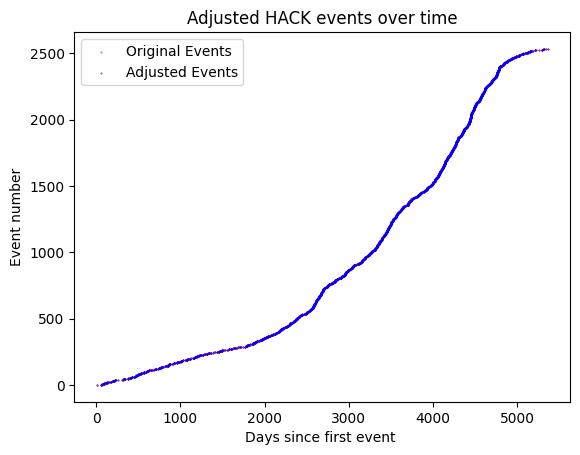

In [238]:
# Count the number of  occurrences of each day
day_counts = Counter(l)
adjusted_l = []

for day, count in day_counts.items():
    if count == 1:
        adjusted_l.append(day)
    else: #Randomly distribute events within the day for multiple occurrences within the same day
        offsets = np.random.uniform(0, 0.99, count)
        for offset in offsets:
            adjusted_l.append(day + offset)
adjusted_l = np.sort(np.array(adjusted_l))
plt.scatter(l, 1 + np.arange(len(adjusted_l)), s=0.1, color='red', label='Original Events')
plt.scatter(adjusted_l, 1 + np.arange(len(adjusted_l)), s=0.1, color='blue', label='Adjusted Events')
plt.title("Adjusted HACK events over time")
plt.xlabel("Days since first event ")
plt.ylabel("Event number")
plt.legend()
plt.show()

Since the adjusted data is overall the same as the initial data, we can start over the parameters optimization :

In [239]:
bounds = [(0.01, 100), (0.01, 100), (0.01, 100)]
n_trials = 10
t_max = adjusted_l[-1]
results = optimize_params(n_trials, bounds, adjusted_l, t_max)
print(f"Best parameters: {results[0][0]}, log-likelihood: {results[0][1]}")
print(f"Second best parameters: {results[1][0]}, log-likelihood: {results[1][1]}")
print(f"Third best parameters: {results[2][0]}, log-likelihood: {results[2][1]}")

Progress: 100%|██████████| 10/10 [03:38<00:00, 21.87s/it]

Best parameters: [0.04326176 0.04369206 0.048067  ], log-likelihood: -1565.094664892128
Second best parameters: [0.0432619  0.04369204 0.048067  ], log-likelihood: -1565.094664892034
Third best parameters: [0.04326178 0.04369202 0.04806697], log-likelihood: -1565.0946648918289


To verify the values obtained, we want to estimate how close a simulated Hawkes process with those parameters is to our data, in terms of inter-arrival times.

In the course, we saw that we can simulate a Hawkes process knowing the parameters, by choosing the number of jumping times (but we cannot choose when we stop).

To do so, we need to solve for $n \geq 2$ :

$ y(N,T_{n+1}) = Z_n $, with $ Z_n \sim \mathcal{P}(1) $ iid

And :

$ y(N,T_{n+1}) = \alpha T_{n+1} + \dfrac{\beta}{\gamma} \sum _{j=1} ^{n} (1-e^{-\gamma(T_{n+1}-T_j)}) $

We compute recursively every $(T_n) _{n \geq 1}$ by this method, until we have the same number of values as our initial data.

In [244]:
alpha_opt, beta_opt, gamma_opt = 0.0433, 0.0437, 0.0481 #From previous calculations
def exponential(param): #We saw that we can generate an exponential random variable using a uniform variable with this method
    return (-1/param)*np.log(np.random.uniform(0,1))

In [245]:
def hawkes_simulation():
    n_events = len(adjusted_l)
    Z = np.cumsum([exponential(1) for _ in range(n_events)]) #We simulate the arrival times of a Poisson process with intensity 1
    simulated_hawkes = []
    T1 = exponential(alpha_opt) #We simulate the first event by a Poisson process of intensity alpha, since there are no prior events
    simulated_hawkes.append(T1)
    for n in range(1, len(adjusted_l)):
        def y_func(T_next):
            sum_exp = np.sum(1-np.exp(-gamma_opt*(T_next-np.array(simulated_hawkes))))
            return alpha_opt*T_next + (beta_opt/gamma_opt)*sum_exp
        T_n = scipy.optimize.root_scalar(lambda T_next: y_func(T_next) - Z[n], x0=simulated_hawkes[-1]).root
        simulated_hawkes.append(T_n)
    return np.array(simulated_hawkes)

We compare the distribution of inter-arrival times to see if it matches :

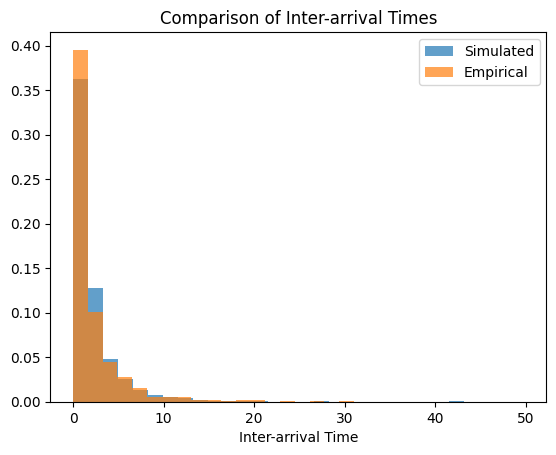

In [246]:
simulated_hawkes = hawkes_simulation()
sim_inter_arrivals = np.diff(simulated_hawkes)
plt.hist(sim_inter_arrivals, bins=30, density=True, alpha=0.7, label='Simulated')
plt.hist(np.diff(adjusted_l), bins=30, density=True, alpha=0.7, label='Empirical')
plt.xlabel('Inter-arrival Time')
plt.title('Comparison of Inter-arrival Times')
plt.legend()
plt.show()

The distributions match.

We have successfully shown that our data matches a Hawkes process of parameters :

- $\alpha = 0.0433$
- $\beta = 0.0437$
- $\gamma = 0.0481$

Since the distributions match.

___

Now that we have an estimate of $y(N,t)$, we know that in theory the following sequence must have the law of a Poisson process of intensity 1 :

$$ (y(N,T_q (N)))_{n \geq 1} \sim \mathcal{P}(1) $$

To verify this asumption, we will compute this sequence, and run tests on the inter-arrivals to see if the sequence matches the law of a Poisson process.

As explained above, we have by theory :

$ y(N,T_{n+1}) = Z_n $, with $ Z_n \sim \mathcal{P}(1) $ iid

And :

$ y(N,T_{n+1}) = \alpha T_{n+1} + \dfrac{\beta}{\gamma} \sum _{j=1} ^{n} (1-e^{-\gamma(T_{n+1}-T_j)}) $

In [248]:
def compute_time_transformed():
    transformed_times = []
    for n in range(len(adjusted_l)):
        T_n = adjusted_l[n]
        history = adjusted_l[:n]
        sum_exp = np.sum((1-np.exp(-gamma_opt*(T_n-history))))
        TqN = alpha_opt*T_n+(beta_opt/gamma_opt) * sum_exp
        transformed_times.append(TqN)
    return np.array(transformed_times)

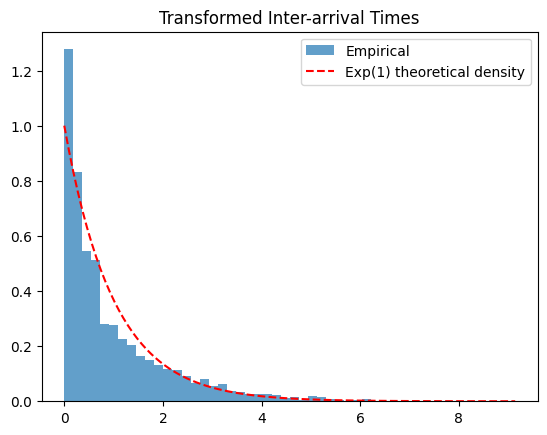

In [250]:
transformed_times = compute_time_transformed()
data_inter_arrivals = np.diff(transformed_times)

#We compare the distribution of inter-arrival times of our data with the theoretical distribution Exp(1)
plt.hist(data_inter_arrivals, bins=50, density=True, alpha=0.7, label="Empirical")
x = np.linspace(0, np.max(data_inter_arrivals), 100)
plt.plot(x, np.exp(-x), 'r--', label="Exp(1) theoretical density")
plt.title("Transformed Inter-arrival Times")
plt.legend()
plt.show()

Graphically, the distributions match, so we succesfully showed that :

$$ (y(N,T_q (N)))_{n \geq 1} \sim \mathcal{P}(1) $$

#### Note :

I didn't use any statistical test to see if the distributions were indeed matching, because the statistical tests provided by scipy are testing for continuous density functions, unlike what we are using here (only discrete data, both simulated and initial data).